Optional if you want qt

In [1]:
# %matplotlib qt

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# torchvision maskrcnn on volpy data
This closely follows the following tutorial:      
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

Especially follows it at beginning, but deviates in the training step. I will note where it deviates.

In [39]:
import colorsys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.color import rgb2gray, gray2rgb
from skimage.draw import polygon2mask
import os

import torch
import torchvision
from torchvision import tv_tensors
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision.tv_tensors import Mask, BoundingBoxes
from torchvision.transforms.v2 import functional as F
import torchvision.transforms.v2 as T
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


# Define some helper functions
**Note:** some of these I used early on exploring the volpy data but then found other functions pre-built or in mrcnnn and imported them here, so this is far from clean/finished -- it's a WIP!!

In [13]:
class ScaleImage:
    """
    Scale image so it is between 0-1: works on floats only

    Note normalize is (x-mean)/std
    You can use this to get data in [0,1] if you define
    mean as x.min(), and std as x.max()-x.min()  

    This was suggested by Nicolas Hug, see: https://github.com/pytorch/vision/issues/6753#issuecomment-1884978269
    """
    def __call__(self, img):
        min_val = img.min()
        max_val = img.max()
        range = max_val - min_val
        return F.normalize_image(img, mean=[min_val, min_val, min_val], std=[range, range, range])

def vp_load_image(dir, fnames, ind):
    """
    np.load image from directory, given list of fnames, and index   

    Input:
    dir: directory containing images
    fnames: list of filenames, sorted
    ind: index of desired image

    Returns:
    image
    full path to file
    """
    fname = fnames[ind]
    return np.load(dir + fname)['img'], dir + fname
    
def plot_volpy_segs(image, masks, min_v, max_v, outline_color, outline_width, figsize=(6,10), title=None):
    """
    plot volpy mask outlines

    image from volpy is mean, mean, corr
    """
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=figsize, sharex=True, sharey=True)  # w/h

    # Mean
    ax1.imshow(image[:,:,1], cmap='gray', 
               vmin=np.percentile(image[:,:,1], min_v), 
               vmax=np.percentile(image[:,:,1], max_v));
    ax1.set_title('Mean Image')
    ax2.imshow(image[:,:,1], cmap='gray', 
               vmin=np.percentile(image[:,:,1], min_v), 
               vmax=np.percentile(image[:,:,1], max_v));
    for mask in masks:
        ax2.plot(mask['all_points_x'], 
                 mask['all_points_y'], 
                 color=outline_color, 
                 linewidth=outline_width);
    ax2.set_title('Mean Image Seg')
    
    # Corr
    ax3.imshow(image[:,:,2], cmap='gray', 
               vmin=np.percentile(image[:,:,2], min_v), 
               vmax=np.percentile(image[:,:,2], max_v));
    ax3.set_title('Corr Image')
    ax4.imshow(image[:,:,2], cmap='gray', 
               vmin=np.percentile(image[:,:,2], min_v), 
               vmax=np.percentile(image[:,:,2], max_v));
    for mask in masks:
        ax4.plot(mask['all_points_x'], 
                 mask['all_points_y'], 
                 color=outline_color, 
                 linewidth=outline_width);
    ax4.set_title('Corr Image Seg')

    if title is not None:
        plt.suptitle(title, y=0.99, fontsize=16);
        
    plt.tight_layout()
    
def bounding_box(mask_coords):
    """
    note coords are in y/x!
    """
    x_vals = mask_coords[:,1]
    y_vals = mask_coords[:,0]
    return [(min(x_vals), min(y_vals)), (max(x_vals), max(y_vals))]

def create_mask(shape, mask_dict):
    """
    from volpy dict representation of mask, create standard rxc mask 

    params:
        shape (rxc) image.shape
        mask_dict (volpy representation of mask that includes 'all_points_x' and 'all_points_y' keys)
    returns:
        rxc Boolean mask
    """
    y_points = mask_dict['all_points_y']
    x_points = mask_dict['all_points_x']
    mask_coords = np.stack([y_points, x_points]).T
    return polygon2mask(shape, mask_coords)
    
def box_area(bbox):
    """ 
    return sa of bbox (bbox in xmin, ymin, xmax, ymax form)
    """
    return (bbox[3]-bbox[1])*(bbox[2]-bbox[0])
    
def normalize_image(image):
    """
    normalize grayscale image to values between 0 and 1 and make sure it is float32
    """
    image_shifted = image - image.min()
    image_normed = image_shifted/image_shifted.max()
    return np.array(image_normed, dtype=np.float32)
   
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.

    from mrcnn
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors
    
def apply_mask(image, mask, color=(1,0,0), alpha=0.5):
    """
    Apply the given mask to the image. Alpha is opacity, from 0 (transparent) to 1 (opaque)

    From mrcnn
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image
    
def apply_masks(image, data_masks, color=(1,0, 0), alpha=0.5):
    """
    apply many masks (N x H x W) to given image
    adapted from mrcnn
    """
    masked_image = image.copy()
    
    for mask_ind, mask in enumerate(data_masks):
        # print(mask_ind)
        masked_image = apply_mask(masked_image, mask, color, alpha=alpha)
        
    return masked_image
    
def draw_bbox(bbox, color='white', ax=None, line_width=0.5):
    """
    Draw a single rectangular bounding box on given axes object.
    
    Args:
        bbox: xmin, ymin, xmax, ymax
        color: matplotlib color
        alpha : float opaqueness level (0. to 1., where 1 is opaque), default 0.2
        ax : pyplot.Axes object axes object upon which rectangle will be drawn, default None
    
    Returns:
        ax: pyplot.Axes object
        rect: matplotlib Rectangle object
    """
    from matplotlib.patches import Rectangle
    
    if ax is None:
        ax = plt.gca()
        
    box_origin = (bbox[0], bbox[1])
    box_height = bbox[3] - bbox[1] 
    box_width = bbox[2] - bbox[0]

    rect = Rectangle(box_origin, 
                     width=box_width, 
                     height=box_height,
                     color=color, 
                     alpha=1,
                     fill=None,
                     linewidth=line_width)
    ax.add_patch(rect)

    return ax, rect
    
def collate_fn(batch):
    """
    from torchvision utils.py
    """
    return tuple(zip(*batch))
    
def draw_bboxes(bboxes, color='white', ax=None, line_width=0.5):
    """
    given Nx4 bounding boxes, draw them all on given axes object

    Returns axes object and list of rects
    """
    if ax is None:
        ax = pl.gca()

    num_boxes = len(bboxes)
    all_rects = []
    for bbox in bboxes:
        ax, rect = draw_bbox(bbox, color=color, ax=ax, line_width=line_width)
        all_rects.append(rect)
        
    return ax, all_rects

print('loaded')

loaded


In [14]:
image_scaler = ScaleImage()  # puts image in 0,1 range

# Inspect VolPy training data

Set up the Image directories from the summary image and masks file from https://zenodo.org/records/4515768 as follows:

    volpy_training_data/
        images/
            HPC.29.04.npz
            ...
        masks/
            HPC.29.04_mask.npz
            ...        
            
The following `data_dir` variable should be directed to `volpy_training_data`

In [16]:
data_dir = '/mnt/home/mpaez/ceph/volpy_training_data/'

In [17]:
image_dir = data_dir + 'images/' 
image_path_list = list(sorted(os.listdir(os.path.join(data_dir, "images"))))
mask_path_list = list(sorted(os.listdir(os.path.join(data_dir, "masks"))))

Let's do some cursory inspection of one dataset. Note: each image is three channels: channels one and two are mean, channel three is corr image.

In [18]:
dat_ind = 14
data_path = image_path_list[dat_ind]      #'TEG.02.01.npz' # HPC.29.04.npz
mask_path = mask_path_list[dat_ind]  #'TEG.02.01_mask.npz' # HPC.29.04_mask.npz
print(data_path, mask_path)

data_loaded = np.load(data_dir + 'images/' + data_path)
masks_loaded = np.load(data_dir + 'masks/' + mask_path, allow_pickle=True)

L1.01.35.npz L1.01.35_mask.npz


Load up the Images and Masks as numpy arrays 

In [19]:
image = data_loaded['img']
masks = masks_loaded['mask']
image_gray = rgb2gray(image) # note for torch tensors there is also an rgb_to_grayscale transform in torchvision
num_masks = len(masks)
image.shape, masks.shape, num_masks

((512, 128, 3), (65,), 65)

Load up the Images as Tensors

In [20]:
image_tensor = torch.from_numpy(image)
image_tensor = image_tensor.permute(2,0,1)
image_tensor = tv_tensors.Image(image_tensor)
image.shape, image.dtype, image_tensor.shape

((512, 128, 3), dtype('float32'), torch.Size([3, 512, 128]))

Plot the Volpy Segmentation (with Parameters initialized as below)

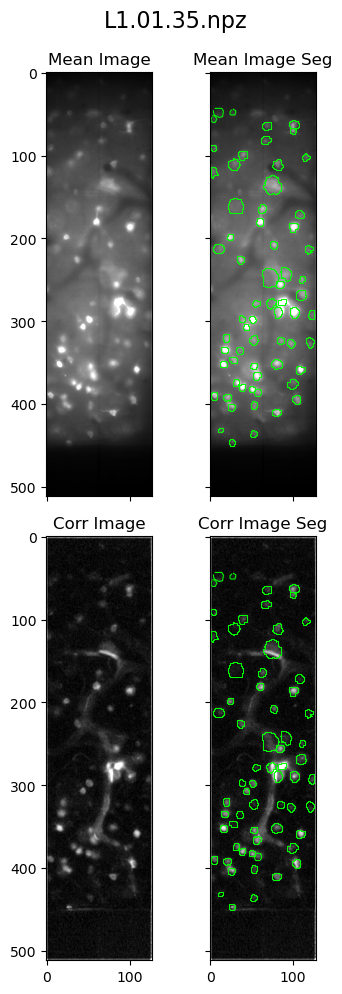

In [23]:
min_v = 1
max_v = 99.5
outline_color = 'lime'
outline_width = 0.75
figure_size = (4,10)
plot_volpy_segs(image, masks, min_v, max_v, outline_color, outline_width, figsize=figure_size, title=data_path)

However, without movie/physiology signals these can be hard to interpret for accuracy. 

# Define the Dataset
Building on the standard `torch.utils.data.Dataset` class is relatively easy:   

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

You have to implement `__len__` and `__getitem__` methods.

The  `__getitem__` method should return an `image` and a `target` dictionary delineating the different objects (box/mask) in the image:

    image: torchvision.tv_tensors.Image of shape [3, H, W]: can be a pure tensor, or a PIL Image of size (H, W)
    target: a dict containing the following keys
        masks : torchvision uint8 binary masks for each object (N,H,W) (N masks)
        boxes (bounding boxes)  (nx4)
        labels (int) label for each bounding box (note 0 is background, so if you have no bg, start with 1)
        image_id (int) unique image id
        area (float) area of bounding box (This may not be technically required)
        iscrowd (uint8) instances with `iscrowd=True` will be ignored during evaluation
    
For `iscrowd`: You might want to focus on clear-cut cases during evaluation. However, during *training*, you almost certainly want to include crowded instances so that the network will learn with them, so this keyword will have no effect during training.

Note on label convention: the model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, define 1 (not 0) to represent cats and 2 to represent dogs. If one of the images has both classes, your labels tensor should look like [1, 2].

In the code below, we are wrapping images, bounding boxes and masks into `torchvision.tv_tensor` classes so that we will be able to apply torchvision transformations for imges/boxes/masks using the same api. Namely, image tensors will be wrapped by `torchvision.tv_tensors.Image`, bounding boxes into `torchvision.tv_tensors.BoundingBoxes` and masks into `torchvision.tv_tensors.Mask`. Since `tv_tensor` objects are `torch.Tensor` subclasses, these objects are also tensors and inherit the plain `torch.Tensor` API.

In the following, if you supply it with transforms for augmentation, the transform will be applied to the image, masks, and bounding boxes. `root` is the name of the base directory.  

In [26]:
class NeuralDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.image_filenames = list(sorted(os.listdir(os.path.join(self.root, "images"))))
        self.mask_filenames = list(sorted(os.listdir(os.path.join(self.root, "masks"))))

    def __getitem__(self, idx):
        image_id = idx

        # Image: (C x H x W)
        image_path = os.path.join(self.root, "images", self.image_filenames[idx])
        image = np.load(image_path)['img'] # mean/mean/corr channels  (h w c)
        image = torch.from_numpy(image).permute(2,0,1) # convert to tensor and get into pytorch order C x H x W
        image = image_scaler(image)   # scale so it is in 0,1 range
        image = tv_tensors.Image(image)

        # Masks: N x H x W mask array (N masks)
        mask_path = os.path.join(self.root, "masks", self.mask_filenames[idx])
        masks_loaded = np.load(mask_path, allow_pickle=True)
        masks = masks_loaded['mask']
        # first create boolean mask stack
        all_masks = []
        for mask_ind, mask_dict in enumerate(masks): # [mask_ind]
            mask = create_mask(image[1].shape, mask_dict)
            all_masks.append(mask)
        all_masks = np.array(all_masks)
        # then convert to binary uint8 tensor stack
        all_masks = torch.from_numpy(all_masks.astype(np.uint8))
                
        boxes = masks_to_boxes(all_masks)
        box_areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  # tensor of areas

        # there is only one class, so labels are all ones
        num_objs = len(masks)
        labels = torch.ones((num_objs,), dtype=torch.int64)

        # let's just say nstances are not crowd: all instances will be used for evaluation
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap up everything into a dictionary describing target
        target = {}
        target["image_id"] = image_id
        target["masks"] = tv_tensors.Mask(all_masks)
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(image))
        target["labels"] = labels
        target["area"] = box_areas
        target["iscrowd"] = iscrowd

        # run augmentation, if transforms exist
        if self.transforms is not None:
            image, target = self.transforms(image, target)
            
        return image, target
        
    def __len__(self):
        return len(self.image_filenames)
        
    def print_image_filenames(self):
        for image_filename in self.image_filenames:
            print(image_filename)

    def print_mask_filenames(self):
        for mask_filename in self.mask_filenames:
            print(mask_filename)

## Volpy training details

From the volpy paper: 
> Training required randomly cropped the input image into *128x128 patches* and applied the following data augmentation techniques using the imgaug package: flip, rotation, multiply (adjust brightness), Gaussian noise, shear, scale and translation` 
>
> Each mini-batch contained *six patches*. We trained on one GPU the head (the whole network except the ResNet) of the network for 20 epochs (2000 iterations) with learning rate 0.01 and then trained the head together with the last 28 layers of the ResNet for another 20 epochs with learning rate 0.001. 
>
> We used stochastic gradient descent as our optimizer with a constant learning momentum 0.9. The weight decay was 0.0001. It is possible that correlations among RGB channels existing in the original COCO datasets are not present in our datasets, however retraining some of the ResNet layers is likely compensating for this potential issue. 
>
> It roughly took 40 minutes to train 40 epochs on a GeForce RTX 2080 Ti GPU with 11 GB of RAM memory. During validation, images were padded with zeroes to make width and height multiples of 64 so that feature maps could be smoothly scaled for the Feature Pyramid Network. We only selected neurons with confidence level greater or equal to 0.7. 
>
> The output components of the network were further filtered based on the number of pixels in each mask. For TEG datasets, masks containing less than 100 pixels were removed. For HPC datasets, masks containing pixels less than 400 were removed. For L1 datasets, there was no constraint on the number of pixels for each mask. 

### Transforms and Augemntations 
There is a new api for transforms that uses the `tv_tensors` class (as explained above, this is why we convert things to `tv_tensors` class)
- https://pytorch.org/blog/extending-torchvisions-transforms-to-object-detection-segmentation-and-video-tasks/
- https://github.com/pytorch/vision/issues/6753
- Enumeration of the transforms: https://pytorch.org/vision/stable/transforms.html

#### Additional Transformations that can be added 
- RandomResize: https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.RandomResize.html#torchvision.transforms.v2.RandomResize
- RandomAdjustSharpness
- RandomAffine: this is probably a good idea I just haven't had a change to play with it.
- There is currently no gaussian noise transform, but we could add one. See the following:
    - https://github.com/pytorch/vision/issues/6192 
    - https://github.com/pytorch/vision/pull/6233
- Rotation works, but I'm not sure it is a good idea; if we use it might want to keep it low (not sure how low fewer than 10 degrees for sure)
- I shut off the 128x128 cropping. I'm not convinced that is a good idea (at least with object detection networks, I have found that if you train on one size, then in val/test data if you deviate from that size, performance suffers pretty badly -- but it works in the following I just commented it out the results seemed less robused in my hands).

Below is the data_transform function that can be edited

In [24]:
def data_transform(train=False):
    transform_pipeline = []
    if train:
        print("Generating training transform pipeline")
        transform_pipeline.append(T.ColorJitter(brightness=0.5, 
                                                contrast=0.5,
                                                saturation=0.5,
                                                hue=0.2))  
        #transform_pipeline.append(T.GaussianBlur(kernel_size=(5,5), 
        #                                                 sigma=(0.01, 0.3))) # sigma min, max 
        transform_pipeline.append(T.RandomHorizontalFlip(p=0.5)) #Horizontal Flip
        transform_pipeline.append(T.RandomVerticalFlip(p=0.5)) #Vertical Flip
        # for rotation: don't go too high. expand resizes so whole image fits in image shape: I find it leads to errors
        transform_pipeline.append(T.RandomRotation(4, fill=0, expand=False))  #Random Rotation 
        transform_pipeline.append(T.SanitizeBoundingBoxes(min_size=2))  #  feel free to tweak min_size -- I found 2 reasonable
        
    # Convert to proper type and compose
    transform_pipeline.append(T.ToDtype(torch.float32, scale=True))
    transform_pipeline.append(T.ToPureTensor())
    return T.Compose(transform_pipeline)

print('transform updated')

transform updated


## Dataset and Dataloader (for Training): 

### Inspecting the Images 
First look at the dataset. For each session it includes image, and the target we generated. 

In [28]:
num_torch_workers = 0 # for windows set to 0, otherwise set to 4+ or whatever

In [29]:
volpy_data = NeuralDataset(data_dir, data_transform(train=True))
volpy_dataloader = torch.utils.data.DataLoader(volpy_data,
                                               batch_size=6,
                                               shuffle=True,
                                               num_workers=num_torch_workers,
                                               collate_fn=collate_fn);
len(volpy_data)

Generating training transform pipeline


24

Prints out Image Files 

In [30]:
volpy_data.print_image_filenames()

HPC.29.04.npz
HPC.29.06.npz
HPC.32.01.npz
HPC.38.03.npz
HPC.38.05.npz
HPC.39.03.npz
HPC.39.04.npz
HPC.39.07.npz
HPC.48.01.npz
HPC.48.05.npz
HPC.48.07.npz
HPC.48.08.npz
L1.00.00.npz
L1.01.00.npz
L1.01.35.npz
L1.02.00.npz
L1.02.80.npz
L1.03.00.npz
L1.03.35.npz
L1.04.00.npz
L1.04.50.npz
TEG.01.02.npz
TEG.02.01.npz
TEG.03.01.npz


Test the indexing (`__getitem__` method). Pull one session see if the keys etc are all reasonable. 

In [31]:
session_ind = 15
dataset_image, dataset_target = volpy_data[session_ind]
dataset_image.shape, type(dataset_image), dataset_target.keys()

(torch.Size([3, 512, 128]),
 torch.Tensor,
 dict_keys(['image_id', 'masks', 'boxes', 'labels', 'area', 'iscrowd']))

Let's pull original image so we can compare original and loaded/transformed.

In [32]:
orig_image, orig_image_path = vp_load_image(image_dir, image_path_list, session_ind)
orig_image.shape, orig_image_path

((512, 128, 3), '/mnt/home/mpaez/ceph/volpy_training_data/images/L1.02.00.npz')

Transform has been applied to image, so they shouldn't be the same.

In [33]:
np.array_equal(orig_image[:,:,0], dataset_image[0,:,:])

False

Inspect original mean, and dataset (mean **transformed**):

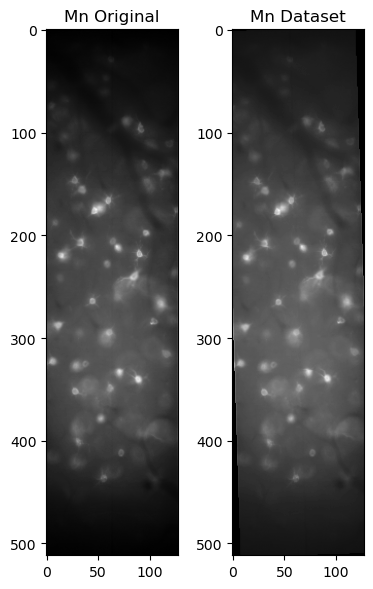

In [34]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(4,6))
ax1.imshow(orig_image[:,:,0], cmap='gray')
ax1.set_title('Mn Original')
ax2.imshow(dataset_image[0,:,:], cmap='gray')
ax2.set_title('Mn Dataset')
plt.tight_layout()

### Inspecting Masks/boxes 

Mean is in first two layers, corr is in third layer of image, convert to rgb so we can more easily display masks etc later. 

In [35]:
summary_mn = gray2rgb(normalize_image(dataset_image[1,:,:]))
summary_corr = gray2rgb(normalize_image(dataset_image[2,:,:]))
data_masks = dataset_target['masks']
data_boxes = dataset_target['boxes']

Print out information from image and target.

In [36]:
print("target image shape", dataset_image.shape)
print("target masks shape", data_masks.shape)
print("target boxes shape", data_boxes.shape)
print("first mask shape", data_masks[0].shape)

target image shape torch.Size([3, 512, 128])
target masks shape torch.Size([63, 512, 128])
target boxes shape torch.Size([63, 4])
first mask shape torch.Size([512, 128])


Set plotting parameters and plot.

You could also in future set different mask colors for each neuron.

In [37]:
mask_color = random_colors(1)[0]
plot_box = True
box_color = 'lime'
opacity=0.35

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..163.54492].



Mean: transformed and with boxes/masks


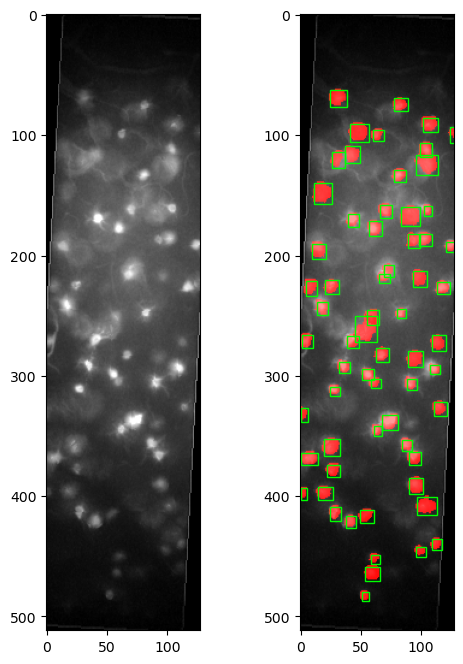

In [22]:
print("\nMean: transformed and with boxes/masks")
masked_mn_vp = apply_masks(summary_mn, data_masks, mask_color, alpha=0.4)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(6,8))
ax1.imshow(summary_mn)
ax2.imshow(masked_mn_vp)
if plot_box:
    ax2, rects = draw_bboxes(data_boxes, color=box_color, line_width=1, ax=ax2);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..214.31476].



Corr: transformed and with boxes/masks


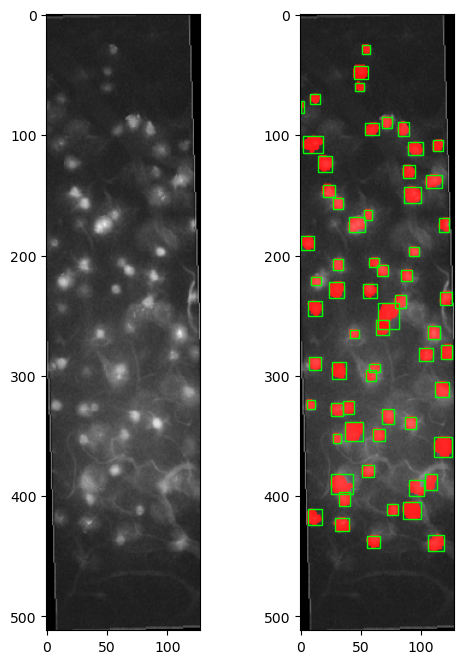

In [38]:
print("\nCorr: transformed and with boxes/masks")
masked_corr_vp = apply_masks(summary_corr, data_masks, mask_color, alpha=0.6)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(6,8))
ax1.imshow(summary_corr)
ax2.imshow(masked_corr_vp)
if plot_box:
    ax2, rects = draw_bboxes(data_boxes, color=box_color, line_width=1, ax=ax2);

### Dataloader inspect
This is what does the majority of the work. It is an iterable. To create an iterator need to `iter(data_loader)`, then can run `next()` to pull the batch out of it that training is run. 

In [23]:
batch_images, batch_targets = next(iter(volpy_dataloader))

# standard way of extracting images and targets for a batch into a list
batch_images = list(image for image in batch_images)
batch_targets = [{k: v for k, v in t.items()} for t in batch_targets]

Plot what we got for one of the batches.

In [24]:
batch_ind = 1
batch_item_target = batch_targets[batch_ind]
batch_item_image = batch_images[batch_ind]
batch_item_id = batch_item_target['image_id']

# extract original image so we can compare
image_orig, image_orig_path = vp_load_image(image_dir, image_path_list, batch_item_id)
print(image_orig_path)

batch_item_id, batch_item_target.keys(), batch_item_image.shape, image_orig.shape

/mnt/home/mpaez/ceph/volpy_training_data/images/TEG.03.01.npz


(23,
 dict_keys(['image_id', 'masks', 'boxes', 'labels', 'area', 'iscrowd']),
 torch.Size([3, 508, 288]),
 (508, 288, 3))

Are they different now that they've gone through loader (and hopefully, transform?)

In [25]:
np.array_equal(image_orig, batch_item_image.permute(1,2,0))

False

Mean


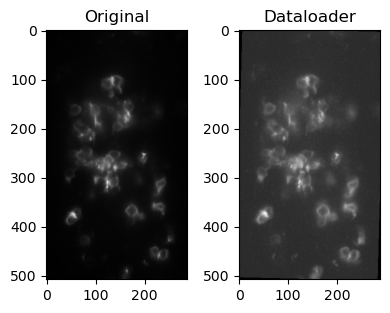

In [26]:
print("Mean")
f, (ax1, ax2) = plt.subplots(1,2, figsize=(4,8))
ax1.imshow(image_orig[:,:,0], cmap='gray')
ax1.set_title('Original')
ax2.imshow(batch_item_image[0,:,:], cmap='gray')
ax2.set_title('Dataloader')
plt.tight_layout()

Corr


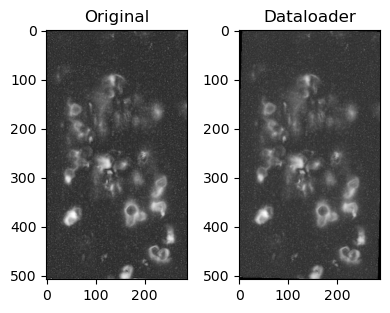

In [27]:
print("Corr")
f, (ax1, ax2) = plt.subplots(1,2, figsize=(4,8))
ax1.imshow(image_orig[:,:,2], cmap='gray')
ax1.set_title('Original')
ax2.imshow(batch_item_image[2,:,:], cmap='gray')
ax2.set_title('Dataloader')
plt.tight_layout()

# Set things up for training

Create a model generator to be ready to be trained and evaluated on the custom dataset.

**Note**: I have not made efforts yet to match the following values used in volpy:    
https://github.com/flatironinstitute/CaImAn/blob/main/caiman/source_extraction/volpy/mrcnn/config.py

Params/defaults in the mask-rcnn can be found here:

https://github.com/pytorch/vision/blob/main/torchvision/models/detection/mask_rcnn.py    
https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py

## Define model
We will start from a pre-trained model trained on the coco dataset, and fine-tune the last layer.

**Note**: this isn't the same as what was done in volpy paper: someone can adapt if performance is not good. volpy paper used a more complicated two-step process (20 epochs with head only, then head + final 28 layers of ResNet for an additional 20 epochs). Right now we are just training the head.

In [46]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

We have two classes (background and neuron)

In [47]:
num_classes = 2

Use our dataset and defined transformations. 

**Note**: the following cell follows the tutorial closely, it will need to be improved. I'd like to have train, validation, and test data as I discuss at the end. Note these are referencing the same dataset, the only difference is the transform being applied to the data.

18 datasets out of 24 for training (75%). Should functionalize this better but for now just doing it manually like they did in torch tutorial.

Split into train and validation set. Just randomize them and split.

In [48]:
# use our dataset and defined transformations
num_test = 4

# training and test datasets defined (this will determine which transforms are applied)
dataset = NeuralDataset(data_dir, data_transform(train=True))
dataset_val = NeuralDataset(data_dir, data_transform(train=False))

print(f"We have {len(dataset)} different volpy datasets to use for training/testing")

indices = torch.randperm(len(dataset)).tolist()
print(indices)

dataset = torch.utils.data.Subset(dataset, indices[:-num_test])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-num_test:])

Generating training transform pipeline
We have 24 different volpy datasets to use for training/testing
[20, 21, 15, 1, 5, 17, 13, 10, 19, 3, 14, 23, 16, 22, 7, 6, 4, 8, 0, 18, 9, 11, 2, 12]


In [49]:
indices[-num_test:]

[9, 11, 2, 12]

In [50]:
num_train = len(dataset)
num_val = len(dataset_val)
print(num_train, num_val)

20 4


Define training and testing data loaders

In [51]:
num_torch_workers = 0  # this is necessary for windows. In other OS set to 4+

In [35]:
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=2,
                                          shuffle=True,
                                          num_workers=num_torch_workers,
                                          collate_fn=collate_fn);
len(data_loader)  # number of batches per epoch 

10

In [52]:
data_loader_val = torch.utils.data.DataLoader(dataset_val,
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=num_torch_workers,
                                               collate_fn=collate_fn)

Get the model using our helper function, and move to the correct device:

In [53]:
model = get_model_instance_segmentation(num_classes)
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

## Set up optimizer/lr scheduler

Note the learning rate is important as if the learning rate is too high initially, you can get NaNs and error during training:

https://github.com/facebookresearch/maskrcnn-benchmark/issues/33

From Volpy paper (note: right now we are just training head):
> We trained on one GPU the head (the whole network except the ResNet) of the network for 20 epochs (2000 iterations) with learning rate 0.01 and then trained the head together with the last 28 layers of the ResNet for another 20 epochs with learning rate 0.001.
>
>We used stochastic gradient descent as our optimizer with a constant learning momentum 0.9. The weight decay was 0.0001. It is possible that correlations among RGB channels existing in the original COCO datasets are not present in our datasets, however retraining some of the ResNet layers is likely compensating for this potential issue.

For more on torch optimizatoin and learning rate schedulring: https://pytorch.org/docs/stable/optim.html

Discussion of learning rate from many sources:    
https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/

*Important*: if you hit NaN values for the loss, then `max_lr` is too high. I like to set `max_lr` as high as possible because the scheduler drops to a very low value so it's basically like simulated annealing.

In [54]:
max_lr = 0.005

In [55]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                            lr=max_lr, # 0.003
                            momentum=0.9,
                            weight_decay=0.0001) #0.0005

optimizer.param_groups[0]["lr"]  # to extract the learning rate

0.005

Build a learning rate scheduler, like to use one that starts low and gets higher (implicit warmup).

Good overview of pytorch LR schedulers here:   
https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863 

In [56]:
from torch.optim.lr_scheduler import CyclicLR
lr_scheduler = CyclicLR(optimizer, 
                     base_lr = 0.000001,     # Initial learning rate which is the lower boundary in the cycle for each parameter group
                     max_lr = max_lr,       # 0.003 Upper learning rate boundaries in the cycle for each parameter group
                     step_size_up = 3,     # Number of training iterations in the increasing half of a cycle
                     step_size_down = 7,
                     mode = "triangular2")

## Run training
The original tutorial uses different metrics for the training and validation data, so it makes it harder to interpret the results if you want to implement an early stopping rule (for instance), so I had to do things quite a bit differently than the tutorial. The following code was adapted from few sources. For instance:

- https://github.com/DatumLearning/Mask-RCNN-finetuning-PyTorch/blob/main/notebook.ipynb
- But also a little inspiration from an OpenCV tutorial ([code here](https://github.com/spmallick/learnopencv/blob/master/Image-Classification-in-PyTorch/image_classification_using_transfer_learning_in_pytorch.ipynb)).
- Some from the `engine.py` file from torchvision.

I played around with higher batch size, higher peak learning rate. Did not seem to help that much, but I didn't do a grid search. As mentioned above, I didn't play around with the parameters sent to the models in `get_model_instance_segmentation()` which will more closely match what you did in the volpy paper. 



In [57]:
model_save_dir = '/mnt/home/mpaez/ceph/volpy_models'

In [59]:
num_epochs = 100
print_freq = 1
save_freq = 20

In [60]:
all_train_losses = []
all_val_losses = []
all_lrs = []

print(f"**TRAIN {num_epochs} epochs. PRINT every {print_freq} epoch(s). SAVE every {save_freq} epoch(s).**")

for epoch in range(num_epochs):      
    train_epoch_loss = 0
    val_epoch_loss = 0

    ### TRAIN STEP
    if np.mod(epoch+1, print_freq) == 0:
        print(f"Epoch {epoch+1}")
    #    print("\tTraining step...")
        
    model.train()
    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum([loss for loss in loss_dict.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    all_train_losses.append(train_epoch_loss)
    all_lrs.append(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation STEP
    #if np.mod(epoch+1, print_freq) == 0:
    #    print("\tTest step...")
    with torch.no_grad():
        for j, (images_val, targets_val) in enumerate(data_loader_val):
            images_val = list(image.to(device) for image in images_val)
            targets_val = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets_val]
            loss_val = model(images_val, targets_val)
            losses_val = sum([l for l in loss_val.values()])
            val_epoch_loss += losses_val.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)
        
    if np.mod(epoch+1, print_freq) == 0:
        print("\ttrain/test net loss: ", train_epoch_loss, " ", val_epoch_loss)

    # Save model (if save)
    if np.mod(epoch+1, save_freq) == 0:
        print(f"\tSaving mrcnn epoch {epoch+1}")
        model_fname = 'mrcnn_' + str(epoch+1) + '.pt'
        model_path = model_save_dir + model_fname
        torch.save(model, model_path)

    torch.cuda.empty_cache()  # may help with memory management
        
history = [all_train_losses, all_val_losses, all_lrs]
torch.save(history, model_save_dir + 'volpy_train_history.pt')
print("\nDONE!")    

**TRAIN 100 epochs. PRINT every 1 epoch(s). SAVE every 20 epoch(s).**
Epoch 1


NameError: name 'data_loader' is not defined

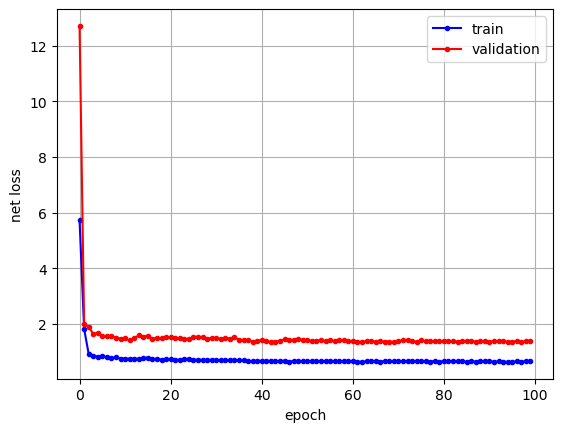

In [47]:
plt.plot(np.array(all_train_losses)/num_train, color='blue', marker='.', label='train')
plt.plot(np.array(all_val_losses)/num_test, color='red', marker='.', label='validation')
plt.legend();
plt.xlabel('epoch')
plt.ylabel('net loss')
plt.grid()

**Note** a weird pattern happens very frequently on the validation data: error will drop very fast (within 3-5 epochs), and then bump up appreciably, and then drop back down. However, if you do traditional early stopping (say, on epoch 5) before the rise in error the results are trash. Maybe it has to do with warmup epochs or something? Could this be the infamous "double dipping" phenomenon in deep learning?

Learning rate vs epoch:

Text(0, 0.5, 'Learning Rate')

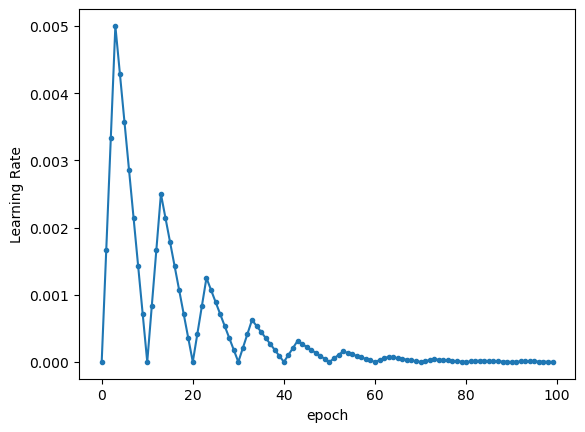

In [58]:
plt.plot(all_lrs, marker='.')
plt.xlabel("epoch")
plt.ylabel("Learning Rate")

# Inference using trained network
**Note** Next iteration of this nb really should leave out a dataset as test data (so we'd have training, validation, and test data). There is quite a bit that could be improved here but I just wanted to get this out for now the basic flow is *roughly* right, and I wanted to give the next person a chance to see it and tinker.

In [63]:
# Pull original data 
data_dir = r'C:/Users/Eric/development/data/volpy_training_data/'
volpy_inference_dataset = NeuralDataset(data_dir, data_transform(train=False))

vp_im, vp_target = volpy_inference_dataset[14]
summary_mn = gray2rgb(normalize_image(vp_im[1,:,:]))
summary_corr = gray2rgb(normalize_image(vp_im[2,:,:]))
data_masks = vp_target['masks']
data_boxes = vp_target['boxes']
data_boxes.shape  # 65 boxes

torch.Size([65, 4])

In [64]:
mask_color = random_colors(1)[0]
plot_box = True
box_color = 'white'
opacity=0.35

Now let's run inference on this dataset

In [65]:
eval_transform = data_transform(train=False)
model.eval()
with torch.no_grad():
    x = eval_transform(vp_im)
    # convert RGBA -> RGB and move to device
    x = x.to(device)
    predictions = model([x, ])
    pred = predictions[0]

In [66]:
# get a sense for the score range
pred['scores']

tensor([0.9426, 0.9354, 0.9335, 0.9272, 0.9132, 0.9128, 0.9107, 0.9098, 0.9045,
        0.9015, 0.9005, 0.8921, 0.8908, 0.8885, 0.8851, 0.8839, 0.8824, 0.8810,
        0.8785, 0.8776, 0.8772, 0.8664, 0.8637, 0.8575, 0.8565, 0.8460, 0.8459,
        0.8416, 0.8402, 0.8330, 0.8321, 0.8221, 0.8202, 0.8183, 0.8108, 0.8091,
        0.8038, 0.7883, 0.7865, 0.7817, 0.7764, 0.7757, 0.7722, 0.7635, 0.7608,
        0.7602, 0.7546, 0.7356, 0.7279, 0.7245, 0.7126, 0.7089, 0.7069, 0.6774,
        0.6389, 0.6306, 0.5809, 0.5557, 0.4967, 0.4925, 0.4786, 0.4775, 0.4594,
        0.3726, 0.3434, 0.3073, 0.2479, 0.2476, 0.2188, 0.2085, 0.2031, 0.1950,
        0.1778, 0.1775, 0.1773, 0.1763, 0.1589, 0.1586, 0.1535, 0.1517, 0.1466,
        0.1441, 0.1402, 0.1357, 0.1296, 0.1263, 0.1230, 0.1228, 0.1219, 0.1200,
        0.1180, 0.1170, 0.1114, 0.1079, 0.1031, 0.0999, 0.0972, 0.0842, 0.0832,
        0.0817], device='cuda:0')

Make function to extract masks/boxes above a threshold (could modify to return confidence values)

In [67]:
def thresholded_predictions(pred, threshold=0.7):
    """
    get masks and boxes for those above threshold
    """
    numels = len(torch.where(pred['scores'] >= threshold)[0])
    masks = pred['masks'][:numels].squeeze()
    boxes = pred['boxes'][:numels]
    
    return masks, boxes 

Pick threshold and plot. PIcking low for now just to see how things look when we give the network free reign, but can adjust to 0.7 like in paper. 

In [68]:
plot_thresh = 0.4
predicted_masks, predicted_boxes = thresholded_predictions(pred, threshold=plot_thresh) 
predicted_masks.shape, predicted_boxes.shape

(torch.Size([63, 512, 128]), torch.Size([63, 4]))

In [69]:
# benchmark masked
# following is a hack there is some weirdness with mask values returned I need to fix
predicted_masks_np = (0.1+predicted_masks).detach().cpu().numpy().astype(np.uint8) 

In [70]:
# get masked image of ground truth and predictions
mask_alpha = 0.001
mask_color = (0,1,0)

masked_vp = apply_masks(summary_mn, data_masks, color=mask_color, alpha=mask_alpha) 
masked_pred = apply_masks(summary_mn, predicted_masks_np, color=mask_color, alpha=mask_alpha);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


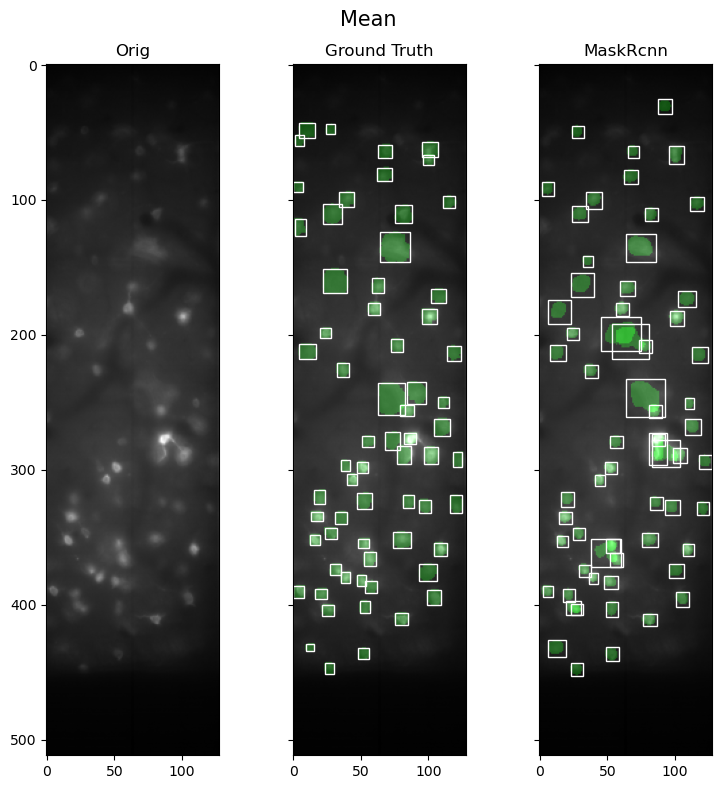

In [72]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,8), sharex=True, sharey=True)
ax1.imshow(summary_mn)
ax2.imshow(masked_vp)
ax3.imshow(masked_pred)
if plot_box:
    ax2, rects = draw_bboxes(data_boxes, ax=ax2, line_width=1, color='white');
    ax3, rect = draw_bboxes(predicted_boxes.detach().cpu().numpy(), ax=ax3, color='white', line_width=1);
ax1.set_title('Orig')
ax2.set_title('Ground Truth')
ax3.set_title('MaskRcnn')
plt.suptitle('Mean', fontsize=15)
plt.tight_layout();

Just by eye this looks decent given that I haven't really done anything with the parameters, but **caveat emptor** it was probably in the training data so that's *not* good (see discussion at start of this section on adding test data). 

Obviously what we want are avoiding false positives (some false negatives are actually ok). I set the threshold very low here (0.4) just to get a sense for the types of false positives we would see. 

**Note**. Just a couple of thoughts: it might be nice to plot boxes in same plot in different colors (maybe with or without mask), obviously do some F1 stats etc for now I jut wanted to get this to you now that the basic logic is worked out. For test dataset we could use proper evaluation metrics (coco evaluation metrics) in addition to the standard loss: this is done in the tutorial. 